In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import layers
from keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Concatenate, Flatten, Conv2D, AveragePooling2D, MaxPool2D, Reshape, Conv2DTranspose
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import os
import random
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Set seed for reproducibility
seed = 42
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
!git clone https://github.com/femartip/Nuclei-Segmentation.git

Cloning into 'Nuclei-Segmentation'...
remote: Enumerating objects: 96236, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 96236 (delta 0), reused 0 (delta 0), pack-reused 96233
Receiving objects: 100% (96236/96236), 555.91 MiB | 35.72 MiB/s, done.
Resolving deltas: 100% (11826/11826), done.
Updating files: 100% (92415/92415), done.


In [4]:
%cd Nuclei-Segmentation/

/kaggle/working/Nuclei-Segmentation


# Load Images

In [5]:
TRAIN_PATH = './processed_data/train/'
TRAIN_MASK_PATH = './processed_data/train_mask/'
VAL_PATH = './processed_data/val/'
VAL_MASK_PATH = './processed_data/val_mask/'

X_train_arrays = []
for filename in os.listdir(TRAIN_PATH):
    image = Image.open(os.path.join(TRAIN_PATH, filename))
    image_array = np.array(image)
    image_array = np.expand_dims(image_array, axis=-1)
    X_train_arrays.append(image_array)
X_train = np.stack(X_train_arrays, axis=0)

X_val_arrays = []
for filename in os.listdir(VAL_PATH):
    image = Image.open(os.path.join(VAL_PATH, filename))
    image_array = np.array(image)
    image_array = np.expand_dims(image_array, axis=-1)
    X_val_arrays.append(image_array)
X_val = np.stack(X_val_arrays, axis=0)

y_train_arrays = []
for filename in os.listdir(TRAIN_MASK_PATH):
    image = Image.open(os.path.join(TRAIN_MASK_PATH, filename))
    image_array = np.array(image)
    bool_array = image_array != 0
    bool_array = np.expand_dims(bool_array, axis=-1)
    y_train_arrays.append(bool_array)
y_train = np.stack(y_train_arrays, axis=0)

y_val_arrays = []
for filename in os.listdir(VAL_MASK_PATH):
    image = Image.open(os.path.join(VAL_MASK_PATH, filename))
    image_array = np.array(image)
    bool_array = image_array != 0
    bool_array = np.expand_dims(bool_array, axis=-1)
    y_val_arrays.append(bool_array)
y_val = np.stack(y_val_arrays, axis=0)


In [6]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

(26232, 128, 128, 1)
(26232, 128, 128, 1)
(3028, 128, 128, 1)
(3028, 128, 128, 1)


In [7]:
print(X_train[0].shape)
print(X_train.shape[0]+X_val.shape[0])

(128, 128, 1)
29260


In [8]:
print(X_train[0])
print(y_train[0])

[[[36]
  [37]
  [37]
  ...
  [37]
  [37]
  [36]]

 [[37]
  [36]
  [36]
  ...
  [36]
  [37]
  [35]]

 [[37]
  [37]
  [37]
  ...
  [36]
  [37]
  [36]]

 ...

 [[38]
  [37]
  [37]
  ...
  [50]
  [54]
  [55]]

 [[37]
  [37]
  [37]
  ...
  [46]
  [51]
  [53]]

 [[37]
  [38]
  [38]
  ...
  [43]
  [47]
  [51]]]
[[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [ True]
  [ True]
  [ True]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [ True]
  [ True]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [ True]]]


# Model

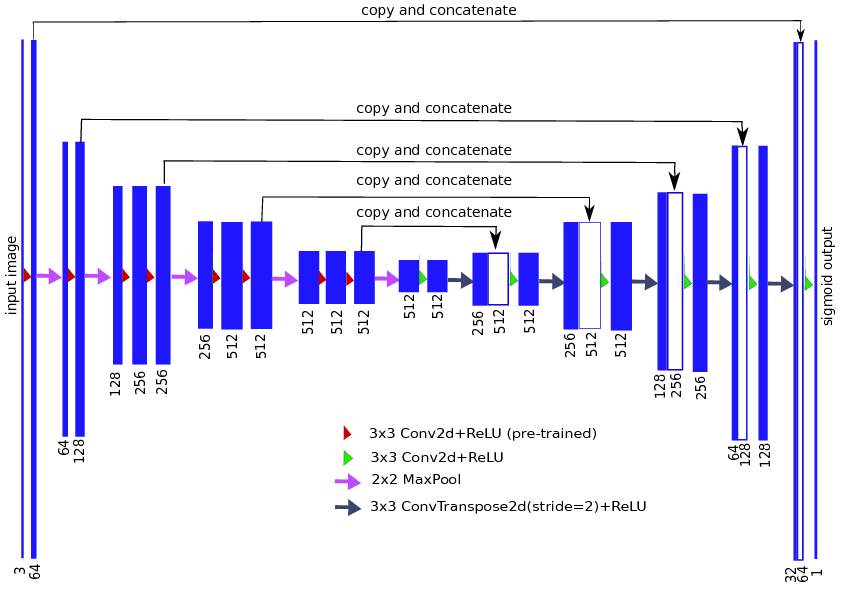

In [9]:
import keras.backend as K

def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f+y_pred_f) + smooth)

In [10]:
def dice_coef_loss(y_true, y_pred):
    return 1.0-dice_coef(y_true, y_pred)

In [11]:
def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    iou = K.mean((intersection + 1) / (union + 1), axis=0)
    return iou

In [12]:
def mean_iou(y_true, y_pred):
    results = []   
    for t in np.arange(0.5, 1, 0.05):
        t_y_pred = tf.cast((y_pred > t), tf.float32)
        pred = iou(y_true, t_y_pred)
        results.append(pred)
        
    return K.mean(K.stack(results), axis=0)

In [13]:
def plot(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['mean_iou'], label='train')
    plt.plot(history.history['val_mean_iou'], label='validation')
    plt.title('Mean IoU')
    plt.legend()
    plt.show()

In [14]:
def big_unet(img_shape):
    input_img = layers.Input(img_shape)

    img_conc = Concatenate()([input_img, input_img, input_img])

    encode_model = VGG16(weights='imagenet', include_top=False, input_tensor=img_conc)

    encode_model.trainable = False

    # output and start upsampling
    features = encode_model.output
    conv_1 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(features)
    conv_1 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(conv_1)
    conv_1 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(conv_1)

    # first concatenation block
    up_conv = layers.UpSampling2D(size=(2,2))(conv_1)
    concat_1 = layers.concatenate([encode_model.get_layer('block5_conv3').output, up_conv], axis=-1)
    conv_2 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(concat_1)
    
    #up_conv_2 = layers.Conv2DTranspose(256, (3,3), strides=(2,2), activation='relu', padding='same')(conv_2)


    # second concatenation block
    up_conv_2 = layers.UpSampling2D(size=(2,2))(conv_2)
    concat_2 = layers.concatenate([up_conv_2, encode_model.get_layer('block4_conv3').output])
    conv_3 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(concat_2)
    
    #up_conv_3 = layers.Conv2DTranspose(128, (3,3), strides=(2,2), activation='relu', padding='same')(conv_3)

    # third concatenation block
    up_conv_3 = layers.UpSampling2D(size=(2,2))(conv_3)
    concat_3 = layers.concatenate([up_conv_3, encode_model.get_layer('block3_conv3').output])
    conv_4 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(concat_3)
    
    #up_conv_4 = layers.Conv2DTranspose(64, (3,3), strides=(2,2), activation='relu', padding='same')(conv_4)

    # fourth concatenation block
    up_conv_4 = layers.UpSampling2D(size=(2,2))(conv_4)
    concat_4 = layers.concatenate([up_conv_4, encode_model.get_layer('block2_conv2').output])
    conv_5 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(concat_4)
    
    #up_conv_5 = layers.Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same')(conv_5)

    # fifth concatenation block
    up_conv_5 = layers.UpSampling2D(size=(2,2))(conv_5)
    concat_4 = layers.concatenate([up_conv_5, encode_model.get_layer('block1_conv2').output])
    conv_6 = layers.Conv2D(64, (3,3), activation='sigmoid', padding='same')(concat_4)

    conv_7 = layers.Conv2D(1, (1,1), activation='sigmoid')(conv_6)

    model = Model(inputs=[encode_model.input], outputs=[conv_7])
    return model

In [15]:
def little_unet(img_shape):
    input_img = layers.Input(img_shape)

    img_conc = Concatenate()([input_img, input_img, input_img])

    encode_model = VGG16(weights='imagenet', include_top=False, input_tensor=img_conc)

    encode_model.trainable = False
    #for layer in encode_model.layers[:-2]:
    #  layer.trainable = False

    # output and start upsampling
    features = encode_model.output
    conv_1 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(features)
    #conv_1 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(conv_1)
    #conv_1 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(conv_1)

    # first concatenation block
    up_conv = layers.UpSampling2D(size=(2,2))(conv_1)
    concat_1 = layers.concatenate([encode_model.get_layer('block5_conv3').output, up_conv], axis=-1)
    conv_2 = layers.Conv2D(128, (3,3), padding='same')(concat_1)
    bn_2 = layers.BatchNormalization()(conv_2)
    act_2 = layers.Activation('relu')(bn_2)
    
    #up_conv_2 = layers.Conv2DTranspose(256, (3,3), strides=(2,2), activation='relu', padding='same')(conv_2)


    # second concatenation block
    up_conv_2 = layers.UpSampling2D(size=(2,2))(act_2)
    concat_2 = layers.concatenate([up_conv_2, encode_model.get_layer('block4_conv3').output])
    conv_3 = layers.Conv2D(128, (3,3), padding='same')(concat_2)
    bn_3 = layers.BatchNormalization()(conv_3)
    act_3 = layers.Activation('relu')(bn_3)
    
    #up_conv_3 = layers.Conv2DTranspose(128, (3,3), strides=(2,2), activation='relu', padding='same')(conv_3)

    # third concatenation block
    up_conv_3 = layers.UpSampling2D(size=(2,2))(act_3)
    concat_3 = layers.concatenate([up_conv_3, encode_model.get_layer('block3_conv3').output])
    conv_4 = layers.Conv2D(64, (3,3), padding='same')(concat_3)
    bn_4 = layers.BatchNormalization()(conv_4)
    act_4 = layers.Activation('relu')(bn_4)
    
    #up_conv_4 = layers.Conv2DTranspose(64, (3,3), strides=(2,2), activation='relu', padding='same')(conv_4)

    # fourth concatenation block
    up_conv_4 = layers.UpSampling2D(size=(2,2))(act_4)
    concat_4 = layers.concatenate([up_conv_4, encode_model.get_layer('block2_conv2').output])
    conv_5 = layers.Conv2D(32, (3,3), padding='same')(concat_4)
    bn_5 = layers.BatchNormalization()(conv_5)
    act_5 = layers.Activation('relu')(bn_5)
    
    #up_conv_5 = layers.Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same')(conv_5)

    # fifth concatenation block
    up_conv_5 = layers.UpSampling2D(size=(2,2))(act_5)
    concat_4 = layers.concatenate([up_conv_5, encode_model.get_layer('block1_conv2').output])
    conv_6 = layers.Conv2D(16, (3,3), activation='sigmoid', padding='same')(concat_4)

    conv_7 = layers.Conv2D(1, (1,1), activation='sigmoid')(conv_6)

    model = Model(inputs=[encode_model.input], outputs=[conv_7])
    return model

In [17]:
batch_size = 128
batches_per_epoch = int((X_train.shape[0]+X_val.shape[0])/batch_size) 
epochs = 20
LR = 0.001

model = little_unet((128,128,1))

model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=dice_coef_loss, metrics=[mean_iou])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=tf.keras.callbacks.TensorBoard(log_dir='./logs'))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_6 (Concatenate)    (None, 128, 128, 3)  0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['concatenate_6[0][0]']    

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#!ls

In [18]:
tf.keras.models.save_model(model, "./model.h", overwrite=True)
model.save("my_model.tf", overwrite=True)


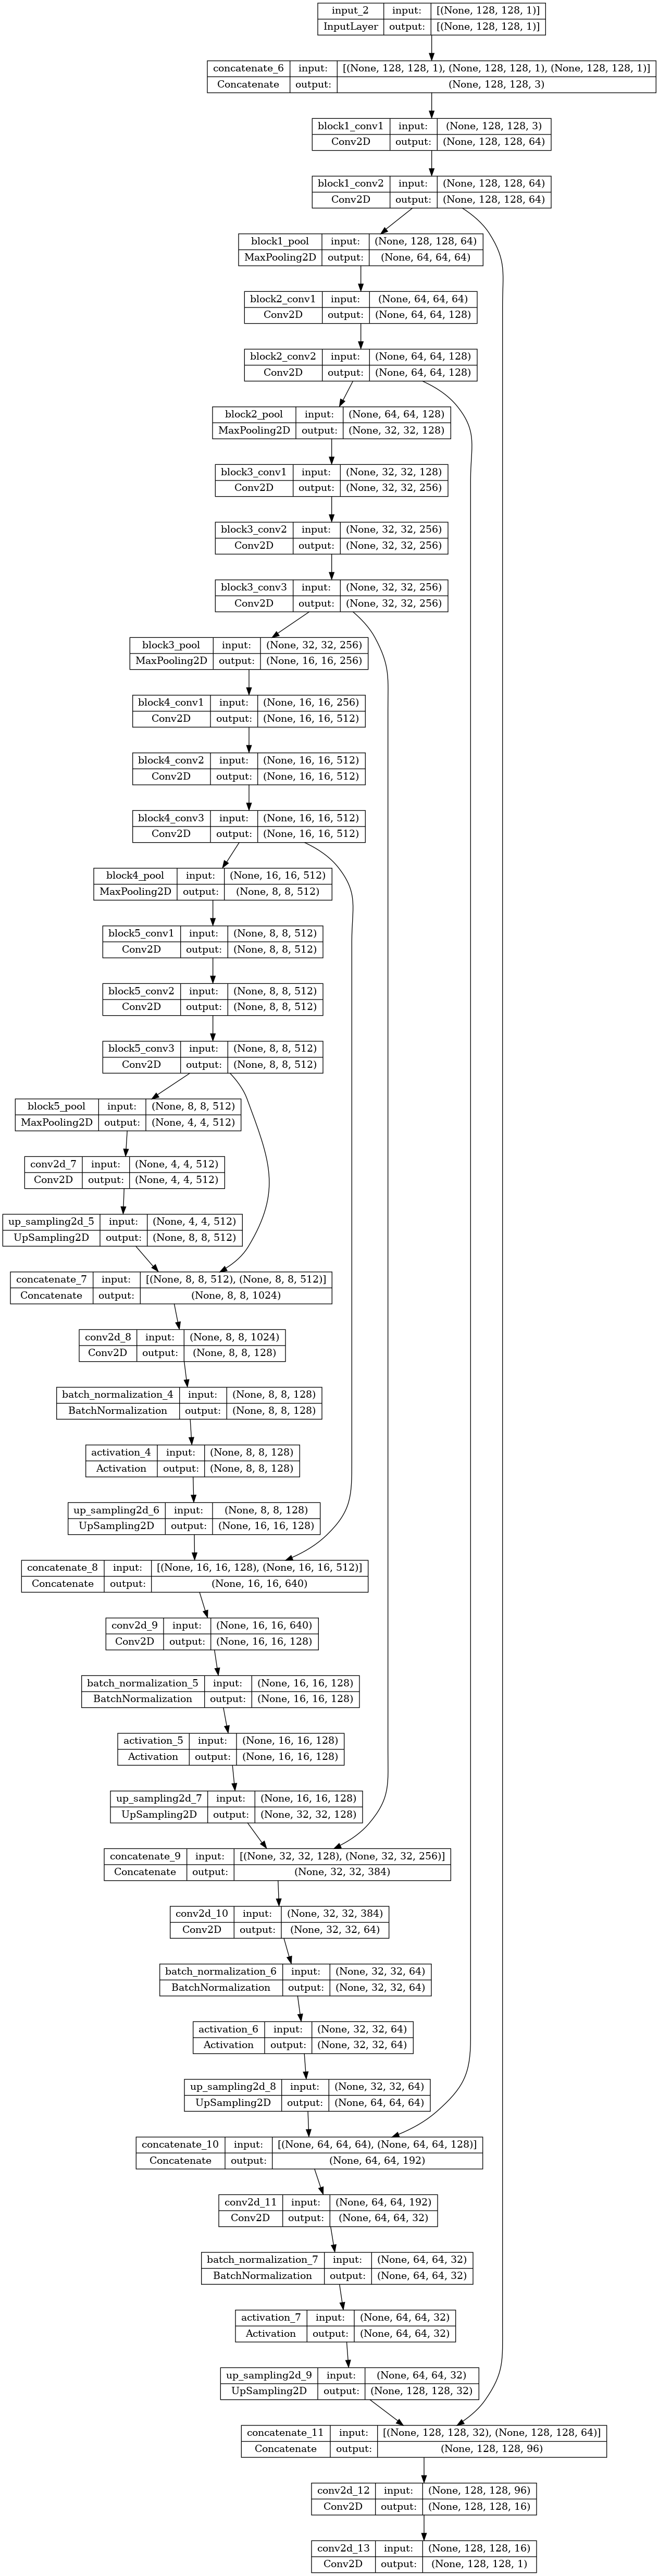

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

In [21]:
print("Final accuracy on train set:", history.history['mean_iou'][-1])
print("Final loss on train set:", history.history['loss'][-1])
print("Final accuracy on validations set:", history.history['val_mean_iou'][-1])
print("Final loss on validations set:", history.history['val_loss'][-1])

Final accuracy on train set: 0.8942533135414124
Final loss on train set: 0.04956002160906792
Final accuracy on validations set: 0.8622363209724426
Final loss on validations set: 0.08265094459056854


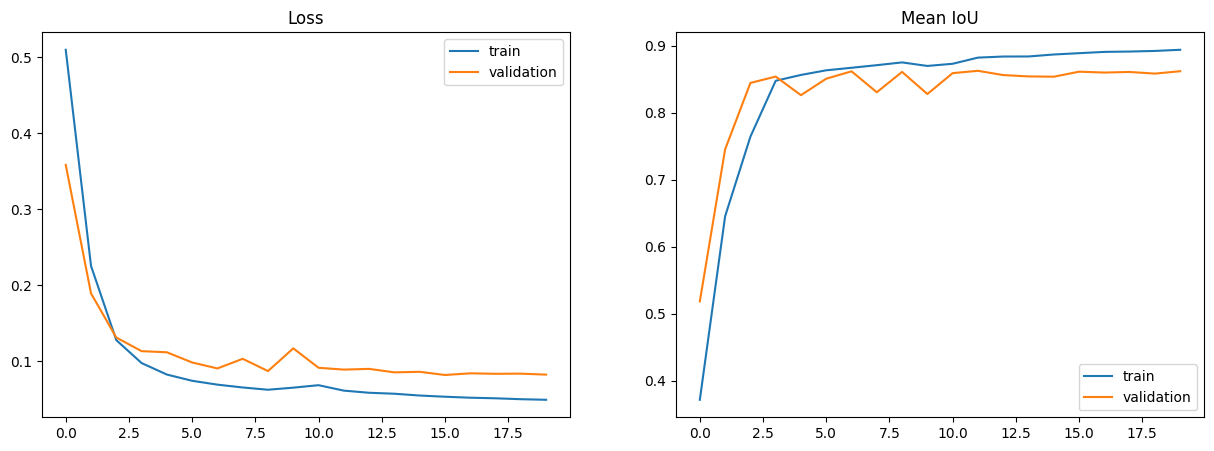

In [22]:
plot(history)

1/1 [==============================] - 0s 22ms/step


TypeError: Invalid shape (1, 128, 128, 1) for image data

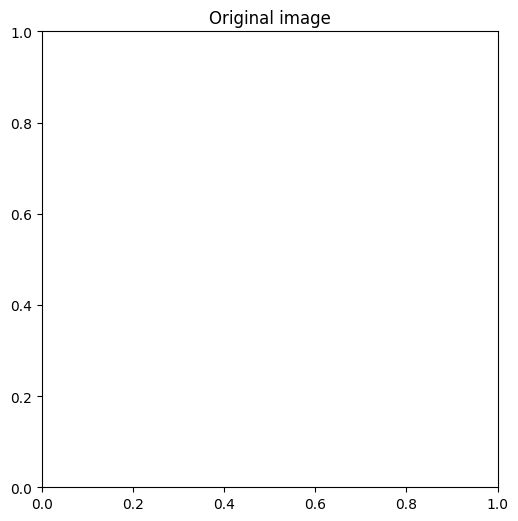

In [30]:
#idx = random.randint(0, len(X_val))
idx = [2540]

for i in idx:
    preds_train = model.predict(X_val[i:i+1], verbose=1)

    #Postprocessing
    preds_train = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.title('Original image')
    plt.imshow(X_val[idx])
    plt.subplot(1,3,2)
    plt.title('Ground truth mask')
    plt.imshow(np.squeeze(y_val[idx]))
    plt.subplot(1,3,3)
    plt.title('Predicted mask')
    plt.imshow(np.squeeze(preds_train))
    plt.show()